In [1]:
import torch as t
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
from torchvision.utils import save_image
import imageio
import os
import math
seed = 7

In [2]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_data = tv.datasets.MNIST("data/train",train=True, download=True, transform = transform)
test_data = tv.datasets.MNIST("data/test",train=False,download=True,transform=transform)

# kwargs = {'num_workers': 10, 'pin_memory': True} # GPU
kwargs = {'num_workers': 1, 'pin_memory': False} # CPU

train_loader = t.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,**kwargs)
test_loader = t.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,**kwargs)

In [3]:
sampleX,sampleY = iter(train_loader).next()
print("The sample data shape is ",sampleX.shape,sampleY.shape)

The sample data shape is  torch.Size([32, 1, 28, 28]) torch.Size([32])


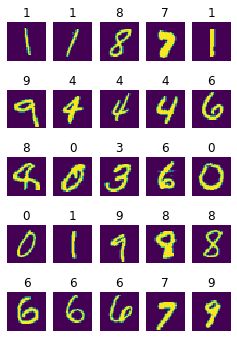

In [4]:
figure = plt.figure(figsize=(4,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.title(sampleY.numpy()[i])
    plt.imshow(sampleX.numpy()[i].squeeze())

In [5]:
use_cuda = t.cuda.is_available()
device = t.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

(60000, 1, 28, 28) (60000,)


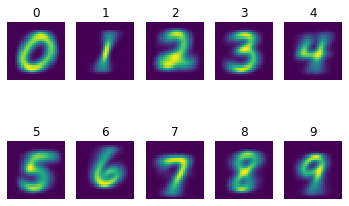

In [6]:
explore_X,explore_y = [],[]
for i in range(len(train_loader)):
    
    X,y = iter(train_loader).next()    
    explore_X.append(X.numpy())
    explore_y.append(y.numpy())
    
explore_X,explore_y = np.array(explore_X).reshape([60000,1,28,28]),np.array(explore_y).reshape([1875*32])
print(explore_X.shape,explore_y.shape)

def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index]

def get_mean_images():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_image = class_arrayX.mean(axis=0)
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.title(i)
        plt.imshow(mean_image.squeeze())
        
get_mean_images()

In [7]:
def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index] 

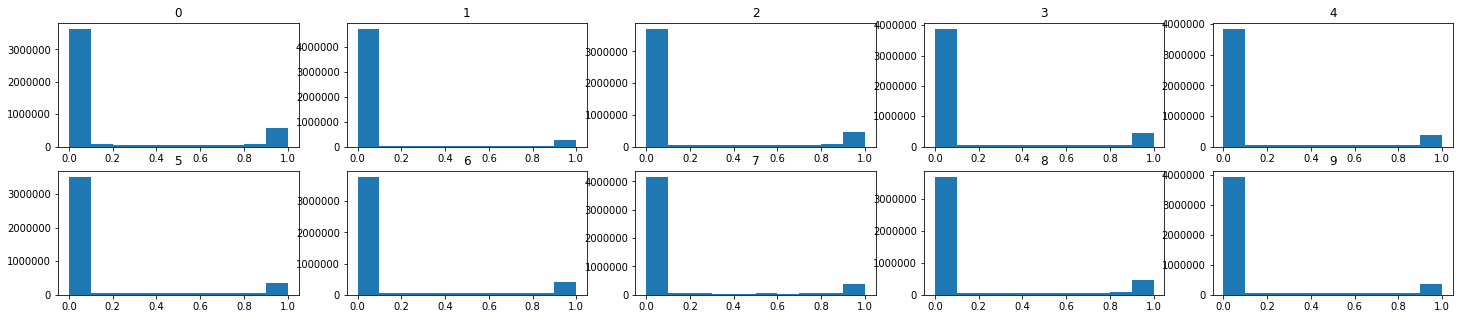

In [8]:
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX.reshape(-1))
        plt.title(i)
get_histogram()

[0.17301616, 0.07591882, 0.14919688, 0.1408593, 0.12073944, 0.12875503, 0.13720505, 0.114649184, 0.15072866, 0.12289709]


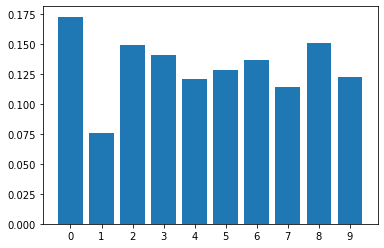

In [9]:
def get_mean_barchart():
    mean_values =[]
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean())
    
    plt.bar(np.arange(10),mean_values, align='center')
    plt.xticks(np.arange(10))
    print(mean_values)

get_mean_barchart()

In [10]:
explore_X.shape

(60000, 1, 28, 28)

# PCA

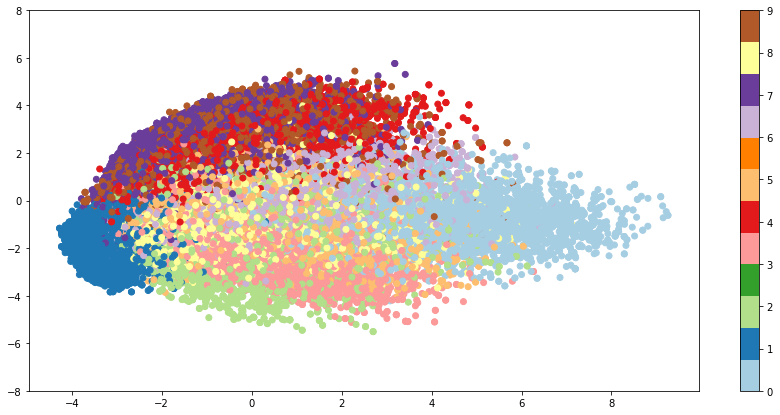

In [11]:
figure = plt.figure(figsize=(15,7))

pca = PCA(n_components=2)
proj = pca.fit_transform(explore_X.reshape(-1,784))
plt.scatter(proj[:, 0], proj[:, 1], c=explore_y, cmap="Paired")
plt.ylim([-8,8])
plt.colorbar(ticks=range(10))

# t-SNE

In [12]:
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings = TSNE(n_jobs=2).fit_transform(explore_X.reshape(-1,784))

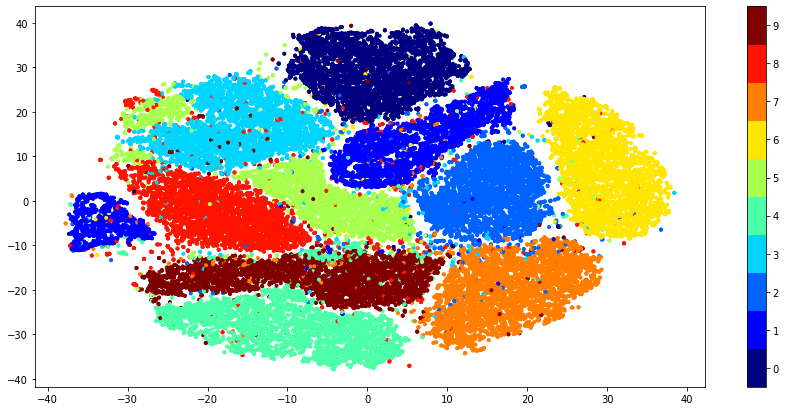

In [13]:
figure = plt.figure(figsize=(15,7))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=explore_y, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

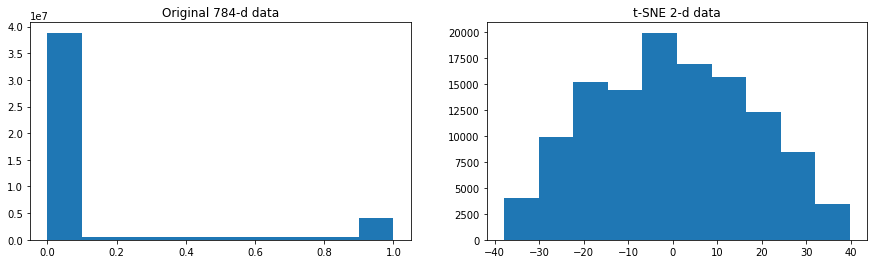

In [14]:
figure = plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
_= plt.hist(explore_X.reshape(-1))
plt.title("Original 784-d data")
plt.subplot(1,2,2)
_= plt.hist(embeddings.reshape(-1))
plt.title("t-SNE 2-d data")
plt.show()

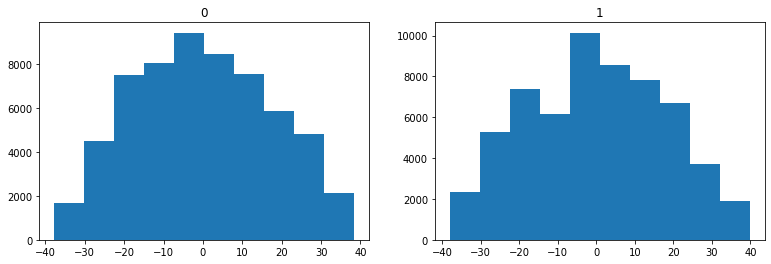

In [15]:
figure = plt.figure(figsize=(13,4))

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(i)
    _= plt.hist(embeddings[:,i])

In [16]:
def get_class_embeddings_arrays(class_index):
    return embeddings[explore_y==class_index],explore_y[explore_y==class_index]

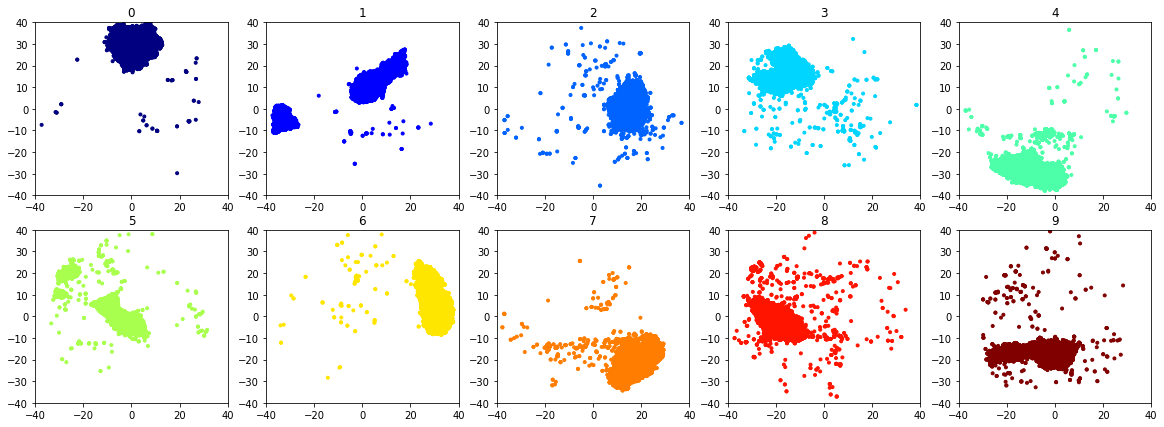

In [17]:
figure = plt.figure(figsize=(20,7))

for i in range(10):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)

# Model Training

In [18]:
class FirstModel(t.nn.Module):
    
    def __init__(self):
        super(FirstModel,self).__init__()
        self.conv1 = t.nn.Conv2d(1,32,3,1)
        self.fc1 = t.nn.Linear(32*26*26,128)
        self.fc2 = t.nn.Linear(128,10)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = x.view(-1,32*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

t.manual_seed(seed)
first_model = FirstModel().to(device)

In [19]:
epochs = 10
learning_rate = 1e-2
momentum = 0.5

criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(first_model.parameters(),lr=learning_rate,momentum=momentum)

In [20]:
def book_keeping(epoch,time,model):
    
    train_correct_predictions = 0
    test_correct_predictions = 0
    train_epoch_loss = 0
    test_epoch_loss = 0

    for batchX,batchY in iter(train_loader):
        
        batchX, batchY = batchX.to(device), batchY.to(device)
        
        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        train_epoch_loss += loss.item()

        predictions = t.argmax(outputs.data, 1)
        train_correct_predictions+= (predictions == batchY).sum().item()
        
    for batchX,batchY in iter(test_loader):
        batchX, batchY = batchX.to(device), batchY.to(device)

        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        test_epoch_loss += loss.item()
        
        predictions = t.argmax(outputs.data, 1)
        test_correct_predictions+= (predictions == batchY).sum().item()
    
    train_acc = (train_correct_predictions / (len(train_loader)*32)) * 100
    test_acc = (test_correct_predictions / (len(test_loader)*32)) * 100
    
    print('Epoch = {}, Time = {}, Train Loss: {:.2f}, Test Loss: {:.2f}, Train Accuracy: {:.2f}%,Test Accuracy: {:.2f}%'.format(epoch + 1, time, train_epoch_loss,test_epoch_loss,train_acc,test_acc))
    
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [21]:
train_losses,test_losses,train_accs,test_accs = [],[],[],[]

In [22]:
kwargs = {'num_workers': 10, 'pin_memory': True} # GPU
# kwargs = {'num_workers': 1, 'pin_memory': False} # CPU

train_loader = t.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,**kwargs)
test_loader = t.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,**kwargs)

In [23]:
def train(model):
    
    for i in range(10):
        start = datetime.now()

        for batchX,batchY in iter(train_loader):

            batchX, batchY = batchX.to(device), batchY.to(device)

            optimizer.zero_grad()
            outputs = model(batchX)

            loss = criterion(outputs,batchY)

            loss.backward()
            optimizer.step()

        end = datetime.now()
        time = (end-start).total_seconds()
        book_keeping(i,time,model)

train(first_model)

Epoch = 1, Time = 4.25842, Train Loss: 340.51, Test Loss: 56.92, Train Accuracy: 94.69%,Test Accuracy: 94.62%
Epoch = 2, Time = 4.175782, Train Loss: 199.01, Test Loss: 35.31, Train Accuracy: 96.77%,Test Accuracy: 96.38%
Epoch = 3, Time = 4.205448, Train Loss: 144.28, Test Loss: 28.24, Train Accuracy: 97.74%,Test Accuracy: 97.13%
Epoch = 4, Time = 4.171802, Train Loss: 122.38, Test Loss: 27.24, Train Accuracy: 98.02%,Test Accuracy: 97.16%
Epoch = 5, Time = 4.18501, Train Loss: 101.22, Test Loss: 24.64, Train Accuracy: 98.38%,Test Accuracy: 97.48%
Epoch = 6, Time = 4.330355, Train Loss: 91.18, Test Loss: 23.34, Train Accuracy: 98.50%,Test Accuracy: 97.65%
Epoch = 7, Time = 4.184655, Train Loss: 84.36, Test Loss: 25.94, Train Accuracy: 98.65%,Test Accuracy: 97.26%
Epoch = 8, Time = 4.405501, Train Loss: 70.12, Test Loss: 22.26, Train Accuracy: 98.88%,Test Accuracy: 97.79%
Epoch = 9, Time = 4.168963, Train Loss: 60.18, Test Loss: 21.96, Train Accuracy: 99.04%,Test Accuracy: 97.55%
Epoch =

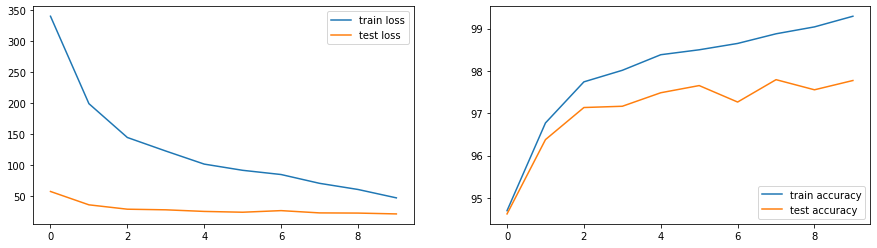

In [24]:
def plot_loss_accs():
    figure = plt.figure(figsize=(15,4))

    labels = ["train loss","test loss"]

    plt.subplot(1,2,1)
    plt.plot(train_losses,label = labels[0])
    plt.plot(test_losses,label = labels[1])
    plt.legend(loc="upper right")

    labels = ["train accuracy","test accuracy"]
    plt.subplot(1,2,2)

    plt.plot(train_accs,label = labels[0])
    plt.plot(test_accs,label = labels[1])
    plt.legend(loc="lower right")
    plt.show()

plot_loss_accs()

In [25]:
class SecondModel(t.nn.Module):
    
    def __init__(self):
        super(SecondModel,self).__init__()
        self.conv1 = t.nn.Conv2d(1,32,3,1)
        self.conv2 = t.nn.Conv2d(32,64,3,1)
        self.fc1 = t.nn.Linear(64*24*24,128)
        self.fc2 = t.nn.Linear(128,10)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,64*24*24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
t.manual_seed(seed)
second_model = SecondModel().to(device)

criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(second_model.parameters(),lr=learning_rate,momentum=momentum)
train_losses,test_losses,train_accs,test_accs = [],[],[],[]

train(second_model)

Epoch = 1, Time = 5.070458, Train Loss: 239.34, Test Loss: 40.63, Train Accuracy: 96.17%,Test Accuracy: 95.99%
Epoch = 2, Time = 5.160444, Train Loss: 162.51, Test Loss: 30.62, Train Accuracy: 97.30%,Test Accuracy: 96.91%
Epoch = 3, Time = 5.009742, Train Loss: 134.05, Test Loss: 26.77, Train Accuracy: 97.80%,Test Accuracy: 97.18%
Epoch = 4, Time = 4.966642, Train Loss: 108.34, Test Loss: 24.75, Train Accuracy: 98.20%,Test Accuracy: 97.35%
Epoch = 5, Time = 5.044853, Train Loss: 90.91, Test Loss: 25.34, Train Accuracy: 98.50%,Test Accuracy: 97.28%
Epoch = 6, Time = 5.114813, Train Loss: 66.21, Test Loss: 21.54, Train Accuracy: 98.91%,Test Accuracy: 97.56%
Epoch = 7, Time = 5.127072, Train Loss: 46.06, Test Loss: 17.58, Train Accuracy: 99.28%,Test Accuracy: 97.89%
Epoch = 8, Time = 5.141362, Train Loss: 39.61, Test Loss: 18.14, Train Accuracy: 99.41%,Test Accuracy: 98.02%
Epoch = 9, Time = 5.315711, Train Loss: 42.46, Test Loss: 22.00, Train Accuracy: 99.31%,Test Accuracy: 97.73%
Epoch 

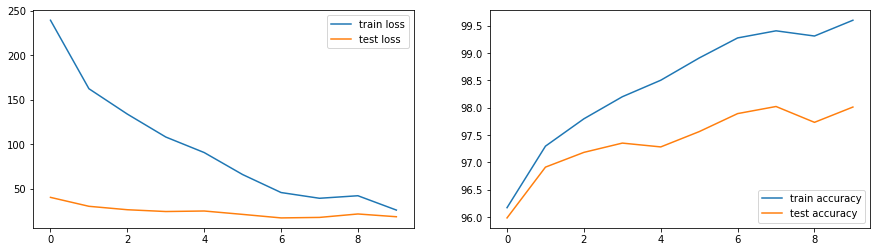

In [26]:
plot_loss_accs()

# Optimizers comparisons

In [27]:
t.manual_seed(seed)
model1 = SecondModel().to(device)

t.manual_seed(seed)
model2 = SecondModel().to(device)

t.manual_seed(seed)
model3 = SecondModel().to(device)

t.manual_seed(seed)
model3 = SecondModel().to(device)

t.manual_seed(seed)
model4 = SecondModel().to(device)

t.manual_seed(seed)
model5 = SecondModel().to(device)

In [28]:
epochs = 10
learning_rate = 1e-2
momentum = 0.5
criterion = t.nn.CrossEntropyLoss()

optimizer1 = t.optim.SGD(model1.parameters(),lr=learning_rate,momentum=momentum)
optimizer2 = t.optim.RMSprop(model2.parameters(),lr=learning_rate,momentum=momentum,alpha=0.50, eps=1e-01)
optimizer3 = t.optim.Adam(model3.parameters(), lr=learning_rate,weight_decay=1e-3)
optimizer4 = t.optim.Adadelta(model4.parameters(), lr=learning_rate,weight_decay=1e-4)
optimizer5 = t.optim.Adagrad(model5.parameters(), lr=learning_rate,eps=1e-03,weight_decay=1e-1)

In [29]:
models = [model1,model2,model3,model4,model5]
optimizers = [optimizer1,optimizer2,optimizer3,optimizer4,optimizer5]
train_losses,test_losses,train_accs,test_accs = [[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]

In [30]:
def book_keeping2(model,model_id,epoch,time):
    
    train_correct_predictions = 0
    test_correct_predictions = 0
    train_epoch_loss = 0
    test_epoch_loss = 0

    for batchX,batchY in iter(train_loader):
        
        batchX, batchY = batchX.to(device), batchY.to(device)
        
        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        train_epoch_loss += loss.item()

        predictions = t.argmax(outputs.data, 1)
        train_correct_predictions+= (predictions == batchY).sum().item()
        
    for batchX,batchY in iter(test_loader):
        batchX, batchY = batchX.to(device), batchY.to(device)

        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        test_epoch_loss += loss.item()
        
        predictions = t.argmax(outputs.data, 1)
        test_correct_predictions+= (predictions == batchY).sum().item()
    
    train_acc = (train_correct_predictions / (len(train_loader)*32)) * 100
    test_acc = (test_correct_predictions / (len(test_loader)*32)) * 100
    
    print('Model = {}, Epoch = {}, Time = {}, Train Loss: {:.2f}, Test Loss: {:.2f}, Train Accuracy: {:.2f}%,Test Accuracy: {:.2f}%'.format(model_id,epoch + 1, time, train_epoch_loss,test_epoch_loss,train_acc,test_acc))
    
    train_losses[model_id-1].append(train_epoch_loss)
    test_losses[model_id-1].append(test_epoch_loss)
    train_accs[model_id-1].append(train_acc)
    test_accs[model_id-1].append(test_acc)

In [31]:
def train_all(batchX,batchY):
    
    for model,optimizer in zip(models,optimizers):
        
        optimizer.zero_grad()
        predictions = model(batchX)
        loss = criterion(predictions,batchY)
        loss.backward()
        optimizer.step()

In [32]:
training_start_time = datetime.now()

for epoch in range(10):
    
    start = datetime.now()
    for batchX,batchY in iter(train_loader):
        batchX, batchY = batchX.to(device), batchY.to(device)

        train_all(batchX,batchY)
        
    end = datetime.now()
    time = (end-start).total_seconds()
        
    for index,model in enumerate(models,1):
        book_keeping2(model,index,epoch,time)

training_end_time = datetime.now()
print("Total training Time is ", (training_end_time-training_start_time).total_seconds())

Model = 1, Epoch = 1, Time = 23.737555, Train Loss: 239.34, Test Loss: 40.63, Train Accuracy: 96.17%,Test Accuracy: 95.99%
Model = 2, Epoch = 1, Time = 23.737555, Train Loss: 92.05, Test Loss: 19.46, Train Accuracy: 98.47%,Test Accuracy: 97.87%
Model = 3, Epoch = 1, Time = 23.737555, Train Loss: 344.80, Test Loss: 57.85, Train Accuracy: 94.45%,Test Accuracy: 94.04%
Model = 4, Epoch = 1, Time = 23.737555, Train Loss: 501.44, Test Loss: 80.02, Train Accuracy: 92.20%,Test Accuracy: 92.32%
Model = 5, Epoch = 1, Time = 23.737555, Train Loss: 594.22, Test Loss: 92.88, Train Accuracy: 91.66%,Test Accuracy: 91.98%
Model = 1, Epoch = 2, Time = 24.09949, Train Loss: 201.81, Test Loss: 36.98, Train Accuracy: 96.63%,Test Accuracy: 96.10%
Model = 2, Epoch = 2, Time = 24.09949, Train Loss: 56.09, Test Loss: 15.44, Train Accuracy: 99.08%,Test Accuracy: 98.25%
Model = 3, Epoch = 2, Time = 24.09949, Train Loss: 404.91, Test Loss: 64.19, Train Accuracy: 93.42%,Test Accuracy: 93.59%
Model = 4, Epoch = 2,

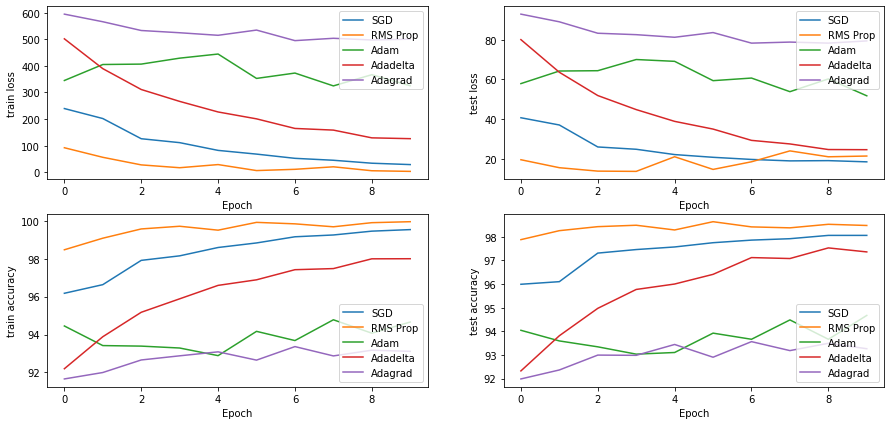

In [33]:
figure = plt.figure(figsize=(15,7))

y_labels = ["train loss","test loss","train accuracy","test accuracy"]
labels = ["SGD","RMS Prop","Adam","Adadelta","Adagrad"]
locs = ["upper right","upper right","lower right","lower right"]

i = 0
for item,y_label,loc in zip([train_losses,test_losses,train_accs,test_accs],y_labels,locs):

    plt.subplot(2,2,i+1)

    plt.plot(item[0], label = labels[0])
    plt.plot(item[1], label = labels[1])
    plt.plot(item[2], label = labels[2])
    plt.plot(item[3], label = labels[3])
    plt.plot(item[4], label = labels[4])

    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend(loc=loc)
    i = i+1


# Final Model With Gradients and Weights

In [34]:
t.manual_seed(seed)
final_model = SecondModel().to(device)

epochs = 10
learning_rate = 1e-2
momentum = 0.5
criterion = t.nn.CrossEntropyLoss()

optimizer = t.optim.RMSprop(final_model.parameters(),lr=learning_rate,momentum=momentum,alpha=0.50, eps=1e-01)

train_losses,test_losses,train_accs,test_accs = [],[],[],[]

In [35]:
models_gradients = []

def save_gradients(model):
    
    global models_gradients
    
    ave_grads = []

    for n, p in model.named_parameters():
        if(p.requires_grad) and ("bias" not in n):
            ave_grads.append(p.grad.abs().mean().item())
            
    models_gradients.append(ave_grads)

In [36]:
def plot_layer(batch_count):
    
    parameters = final_model.parameters()
    
    for i,param in enumerate(parameters):
        
        if i%2==0:
            filename = "weights/layer"+str(i)+"_"+str(batch_count)
            param = param.detach().cpu().numpy()
            counts=plt.hist(param.reshape(-1))
            plt.savefig(filename)
            plt.close()

In [37]:
def train_single_model(model):
    
    batch_count = 1

    for i in range(5):
        start = datetime.now()

        for batchX,batchY in iter(train_loader):

            batchX, batchY = batchX.to(device), batchY.to(device)
            
            optimizer.zero_grad()
            outputs = model(batchX)

            loss = criterion(outputs,batchY)
            
            #this line is not recommneded as it slows down the training 100 times (I did it for weights plotting)
#             plot_layer(batch_count)
            loss.backward()
            save_gradients(model)
            optimizer.step()
            
            batch_count+=1
                    
        end = datetime.now()
        time = (end-start).total_seconds()
        book_keeping(i,time,model)

train_single_model(final_model)

Epoch = 1, Time = 7.110493, Train Loss: 92.05, Test Loss: 19.51, Train Accuracy: 98.47%,Test Accuracy: 97.87%
Epoch = 2, Time = 7.311918, Train Loss: 37.96, Test Loss: 12.40, Train Accuracy: 99.38%,Test Accuracy: 98.61%
Epoch = 3, Time = 7.072282, Train Loss: 27.66, Test Loss: 13.96, Train Accuracy: 99.55%,Test Accuracy: 98.48%
Epoch = 4, Time = 7.348548, Train Loss: 18.03, Test Loss: 14.66, Train Accuracy: 99.71%,Test Accuracy: 98.53%
Epoch = 5, Time = 7.201022, Train Loss: 15.23, Test Loss: 16.76, Train Accuracy: 99.74%,Test Accuracy: 98.41%


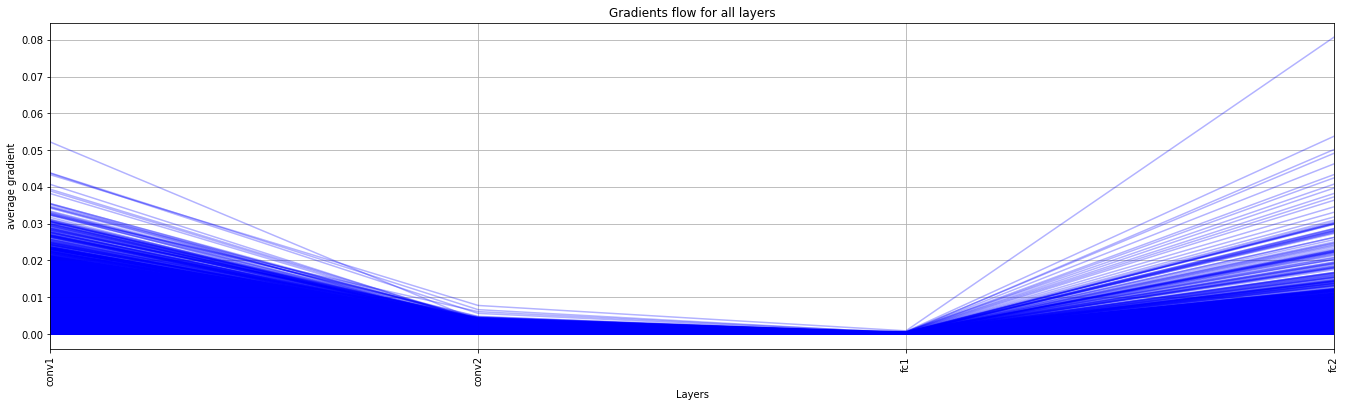

In [38]:
def plot_gradients():
    
    figure = plt.figure(figsize=(23,6))
    layers = []
    
    for n, p in final_model.named_parameters():
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n.split(".weight")[0])
    
    for p in models_gradients:
        plt.plot(p, alpha=0.3, color='b')
    
    plt.hlines(0, 0, 6, linewidth=1, color="k" )
    plt.xticks(range(0,5, 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(layers)-1)
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.grid(True)
    plt.title("Gradients flow for all layers")
    plt.savefig("gradients.png")
    
plot_gradients()

# Weights visualization

(32, 3, 3)


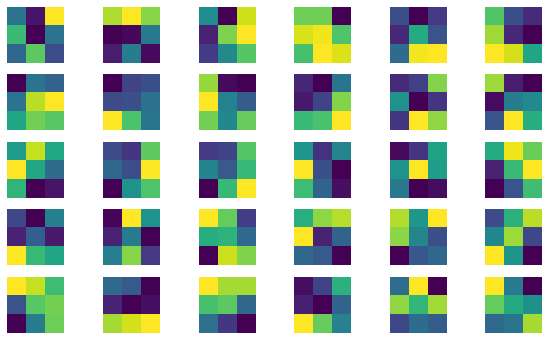

In [39]:
conv1 = [i for i in final_model.children()][0]
conv1_weights = conv1.weight.detach().cpu().numpy().squeeze()
print(conv1_weights.shape)

figure = plt.figure(figsize=(10,6))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis("off")
    plt.imshow(conv1_weights[i])

[[-0.15435152 -0.28357357  0.08600818]
 [-0.03893711 -0.30581194 -0.15691589]
 [-0.17488791 -0.01195139 -0.21348833]]


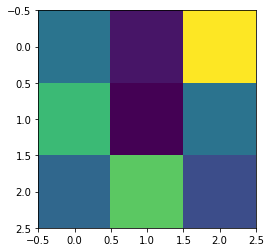

In [40]:
print(conv1_weights[0])
plt.imshow(conv1_weights[0])
plt.show()

[[-0.15435152 -0.28357357  0.08600818]
 [-0.03893711 -0.30581194 -0.15691589]
 [-0.17488791 -0.01195139 -0.21348833]]


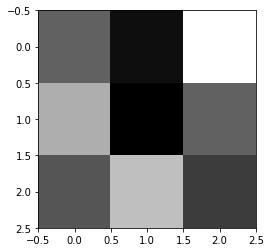

In [41]:
print(conv1_weights[0])
plt.imshow(conv1_weights[0], cmap="gray")
plt.show()

(64, 32, 3, 3)


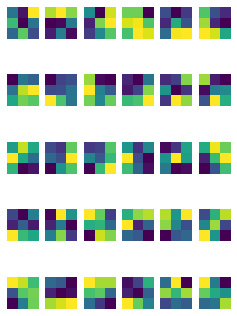

In [42]:
conv2 = [i for i in final_model.children()][1]
conv2_weights = conv2.weight.detach().cpu().numpy().squeeze()
print(conv2_weights.shape)

figure = plt.figure(figsize=(4,6))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis("off")
    plt.imshow(conv1_weights[i])

(10, 128)


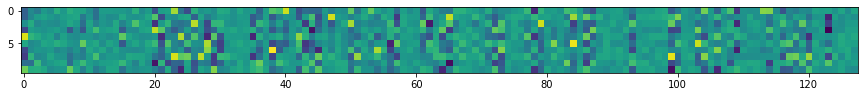

In [43]:
fc2 = [i for i in final_model.children()][3]
fc2_weights = fc2.weight.detach().cpu().numpy().squeeze()
print(fc2_weights.shape)

figure = plt.figure(figsize=(15,6))

plt.imshow(fc2_weights)
plt.show()

# Hidden layers visualization

In [44]:
sampleX = sampleX.to(device)

In [45]:
visual_layer = {}
def get_visual_layer(name):
    def hook(final_model, input, output):
        visual_layer[name] = output.detach().cpu().numpy()
    return hook

(32, 26, 26)


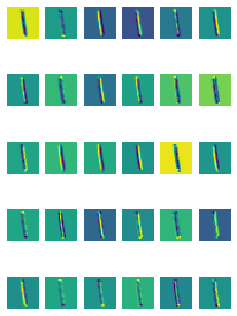

In [46]:
final_model.conv1.register_forward_hook(get_visual_layer('conv1'))
output = final_model(sampleX[0:1])

layer = visual_layer['conv1'].squeeze()
print(layer.shape)

figure = plt.figure(figsize=(4,6))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis("off")
    plt.imshow(layer[i])

(64, 24, 24)


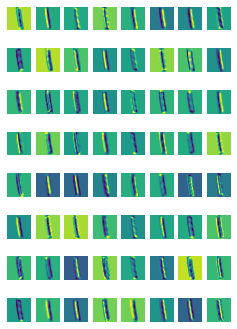

In [47]:
final_model.conv2.register_forward_hook(get_visual_layer('conv2'))
output = final_model(sampleX[0:1])

layer = visual_layer['conv2'].squeeze()
print(layer.shape)

figure = plt.figure(figsize=(4,6))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(layer[i])

(1, 128)


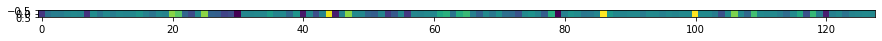

In [48]:
final_model.fc1.register_forward_hook(get_visual_layer('fc1'))
output = final_model(sampleX[0:1])

layer = visual_layer['fc1'].squeeze()
layer = np.expand_dims(layer,axis=0)
print(layer.shape)

figure = plt.figure(figsize=(15,30))
plt.imshow(layer)
plt.show()

(1, 10)
[[-14.290584    9.4065075 -10.516424   -8.463822   -4.3682575  -6.6327124
   -6.9191623  -5.7594504  -7.4437466  -4.234986 ]]


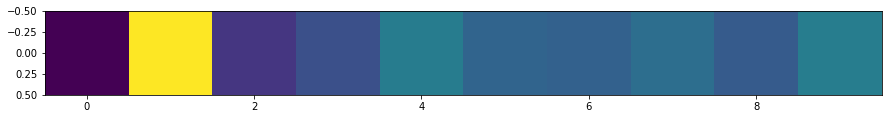

In [49]:
final_model.fc2.register_forward_hook(get_visual_layer('fc2'))
output = final_model(sampleX[0:1])

layer = visual_layer['fc2'].squeeze()
layer = np.expand_dims(layer,axis=0)
print(layer.shape)
print(layer)

figure = plt.figure(figsize=(15,30))
plt.imshow(layer)
plt.show()

(1, 10)
[[-14.290584    9.4065075 -10.516424   -8.463822   -4.3682575  -6.6327124
   -6.9191623  -5.7594504  -7.4437466  -4.234986 ]]


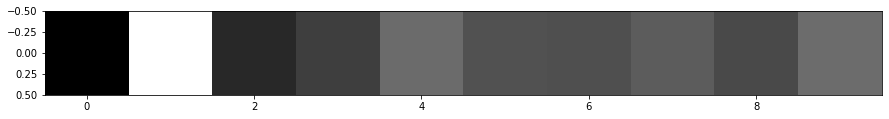

In [50]:
final_model.fc2.register_forward_hook(get_visual_layer('fc2'))
output = final_model(sampleX[0:1])

layer = visual_layer['fc2'].squeeze()
layer = np.expand_dims(layer,axis=0)
print(layer.shape)
print(layer)

figure = plt.figure(figsize=(15,30))
plt.imshow(layer,cmap="gray")
plt.show()

# Transfer Learning

In [51]:
transform = tv.transforms.Compose([tv.transforms.Resize(224),tv.transforms.ToTensor(),tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

train_data = tv.datasets.MNIST("data/train",train=True, download=True, transform = transform)
test_data = tv.datasets.MNIST("data/test",train=False,download=True,transform=transform)

batch_size = 32
kwargs = {'num_workers': 10, 'pin_memory': True}

train_loader = t.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,**kwargs)
test_loader = t.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,**kwargs)

sampleX,sampleY = iter(train_loader).next()
sampleX = sampleX.to(device)
print("The sample data shape is ",sampleX.shape,sampleY.shape)


The sample data shape is  torch.Size([32, 3, 224, 224]) torch.Size([32])


In [52]:
t.manual_seed(seed)
vgg16 = tv.models.vgg16(pretrained=True).to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([t.nn.Linear(num_features, 10)])

vgg16.classifier = t.nn.Sequential(*features).to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
for param in vgg16.features.parameters():
    param.requires_grad = False

for param in vgg16.classifier.parameters():
    print(param.requires_grad)

True
True
True
True
True
True


In [55]:
epochs = 10
learning_rate = 1e-2
momentum = 0.5

criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(vgg16.parameters(),lr=learning_rate,momentum=momentum)
train_losses,test_losses,train_accs,test_accs = [],[],[],[]

In [56]:
batch_count = 1
figure = plt.figure(figsize=(20,6))

for i in range(10):
    epoch_loss, count = 0,0
    start = datetime.now()

    for batchX,batchY in iter(train_loader):
        
        batchX, batchY = batchX.to(device), batchY.to(device)

        optimizer.zero_grad()
        outputs = vgg16(batchX)

        loss = criterion(outputs,batchY)
        
        loss.backward()
        optimizer.step()
    
    end = datetime.now()
    time = (end-start).total_seconds()
    book_keeping(i,time,vgg16)

Epoch = 1, Time = 133.773201, Train Loss: 55.70, Test Loss: 13.13, Train Accuracy: 99.15%,Test Accuracy: 98.35%
Epoch = 2, Time = 135.102753, Train Loss: 31.59, Test Loss: 9.58, Train Accuracy: 99.54%,Test Accuracy: 98.86%
Epoch = 3, Time = 135.456384, Train Loss: 37.63, Test Loss: 13.14, Train Accuracy: 99.35%,Test Accuracy: 98.40%
Epoch = 4, Time = 135.508597, Train Loss: 19.00, Test Loss: 9.60, Train Accuracy: 99.73%,Test Accuracy: 98.81%
Epoch = 5, Time = 135.488726, Train Loss: 10.45, Test Loss: 8.99, Train Accuracy: 99.88%,Test Accuracy: 98.92%
Epoch = 6, Time = 135.566885, Train Loss: 6.04, Test Loss: 8.25, Train Accuracy: 99.97%,Test Accuracy: 98.96%
Epoch = 7, Time = 135.582373, Train Loss: 4.32, Test Loss: 8.92, Train Accuracy: 99.98%,Test Accuracy: 99.00%
Epoch = 8, Time = 135.508802, Train Loss: 3.37, Test Loss: 8.82, Train Accuracy: 99.98%,Test Accuracy: 98.95%
Epoch = 9, Time = 135.542163, Train Loss: 2.23, Test Loss: 8.59, Train Accuracy: 100.00%,Test Accuracy: 99.02%
Ep

<Figure size 1440x432 with 0 Axes>

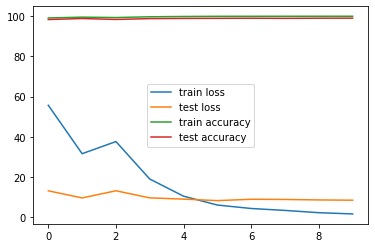

In [57]:
labels = ["train loss","test loss","train accuracy","test accuracy"]

plt.plot(train_losses,label = labels[0])
plt.plot(test_losses,label = labels[1])
plt.plot(train_accs,label = labels[2])
plt.plot(test_accs,label = labels[3])
plt.legend(loc="center")
plt.savefig("final_acc.png")

(64, 3, 3, 3)


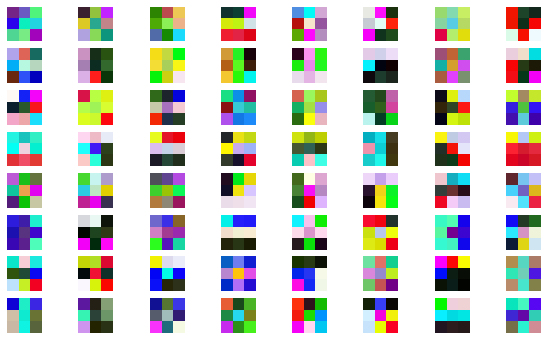

In [58]:
conv1 = [i for i in vgg16.features.children()][0]
conv1_weights = conv1.weight.detach().cpu().numpy().squeeze()
print(conv1_weights.shape)

figure = plt.figure(figsize=(10,6))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow((conv1_weights[i] * 255).astype(np.uint8))

[[[ 59  32  47]
  [147 194  62]
  [193  36 255]]

 [[221 201  38]
  [ 42 167 143]
  [195 132 137]]

 [[176 162 223]
  [136 217  88]
  [ 13 149 126]]]


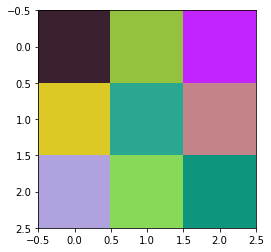

In [59]:
print((conv1_weights[1] * 255).astype(np.uint8))
plt.imshow((conv1_weights[1] * 255).astype(np.uint8))
plt.show()

In [60]:
visual_VGG_layer = {}
def get_VGG_visual_layer(name):
    def hook(vgg16, input, output):
        visual_VGG_layer[name] = output.detach().cpu().numpy()
    return hook

(64, 224, 224)


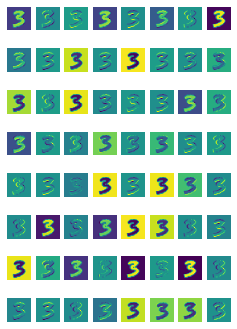

In [61]:
vgg16.features[0].register_forward_hook(get_VGG_visual_layer('0'))
output = vgg16(sampleX[0:1])

layer = visual_VGG_layer['0'].squeeze()
print(layer.shape)

figure = plt.figure(figsize=(4,6))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(layer[i])

In [62]:
def save_layer_wise_images():
    
    for l in range(1,32):
        model  = list(vgg16.features.children())[:l]

        explore_model = t.nn.Sequential(*model).to(device)

        conv_outputs = explore_model(x[1:2])
        conv_outputs = conv_outputs.cpu().numpy().squeeze()
        print(conv_outputs.shape)

        figure = plt.figure(figsize=(5,7))
        figure.suptitle("layer"+str(l)+" "+str(conv_outputs.shape), fontsize=20)

        for i in range(64):
            plt.subplot(8,8,i+1)
            plt.axis("off")
            plt.imshow(conv_outputs[i])

        plt.savefig("vgg/layer"+str(l)+".png")
        plt.close()
        
# save_layer_wise_images() #only for plotting

# Conditaion GAN training

In [63]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_data = tv.datasets.MNIST("data/train",train=True, download=True, transform = transform)
test_data = tv.datasets.MNIST("data/test",train=False,download=True,transform=transform)

batch_size = 100
kwargs = {'num_workers': 10, 'pin_memory': True}

train_loader = t.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,**kwargs)
test_loader = t.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,**kwargs)

In [64]:
class Generator(t.nn.Module):
    
    def __init__(self,z_dim):
        super(Generator,self).__init__()
        self.fc1_1 = t.nn.Linear(z_dim,256)
        self.fc1_2 = t.nn.Linear(10,256)
        
        self.fc2 = t.nn.Linear(512,512)
        self.fc3 = t.nn.Linear(512,1024)
        self.fc4 = t.nn.Linear(1024,784)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self,x,y):
        
        x1 = F.leaky_relu(self.fc1_1(x),0.2)
        x2 = F.leaky_relu(self.fc1_2(y),0.2)
        x = t.cat([x1, x2], 1)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = F.leaky_relu(self.fc3(x),0.2)
        x = t.tanh(self.fc4(x))
        
        return x

In [65]:
class Discriminator(t.nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()
        self.fc1_1 = t.nn.Linear(784,1024)
        self.fc1_2 = t.nn.Linear(10,1024)

        self.fc2 = t.nn.Linear(2048,512)
        self.fc3 = t.nn.Linear(512,256)
        self.fc4 = t.nn.Linear(256,1)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self,x,y):
        
        x1 = F.leaky_relu(self.fc1_1(x),0.2)
        x2 = F.leaky_relu(self.fc1_2(y),0.2)
        x = t.cat([x1, x2], 1)
        
        x = F.leaky_relu(self.fc2(x),0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc3(x),0.2)
        x = F.dropout(x, 0.3)

        x = t.sigmoid(self.fc4(x))
        
        return x


In [66]:
def normal_init(m, mean, std):
    if isinstance(m, t.nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [67]:
z_dim = 100
learning_rate = 0.0002

t.manual_seed(seed)
G = Generator(z_dim)
G.weight_init(mean=0, std=0.02)
G = G.to(device)

t.manual_seed(seed)
D = Discriminator()
D.weight_init(mean=0, std=0.02)
D = D.to(device)

In [68]:
criterion = t.nn.BCELoss() 

G_optimizer = t.optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = t.optim.Adam(D.parameters(), lr = learning_rate)

In [69]:
def train_discriminator(x_real,y_real):
    D.zero_grad()
    
    y_one_hot = t.zeros(batch_size, 10).to(device)
    y_one_hot = y_one_hot.scatter_(1, y_real.view(batch_size, 1), 1)
    y_one_hot = y_one_hot.to(device)
    
    gan_real_labels = Variable(t.ones(batch_size, 1).to(device))

    D_real_outputs = D(x_real,y_one_hot)
    D_real_loss = criterion(D_real_outputs, gan_real_labels)

    latent_z = Variable(t.randn(batch_size, z_dim).to(device))
    gan_fake_labels = Variable(t.zeros(batch_size, 1).to(device))
    
    G_samples = G(latent_z,y_one_hot)
    D_fake_outputs = D(G_samples,y_one_hot)
    D_fake_loss = criterion(D_fake_outputs, gan_fake_labels)
    
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return  D_loss.data.item()

In [70]:
def train_generator(y_real):

    G.zero_grad()
    
    y_one_hot = t.zeros(batch_size, 10).to(device)
    y_one_hot = y_one_hot.scatter_(1, y_real.view(batch_size, 1), 1)
    y_one_hot = y_one_hot.to(device)
    
    gan_fake_labels = Variable(t.ones(batch_size, 1).to(device))
    
    latent_z = Variable(t.randn(batch_size, z_dim).to(device))
    G_samples = G(latent_z,y_one_hot)
    D_fake_outputs = D(G_samples,y_one_hot)
    
    G_loss = criterion(D_fake_outputs, gan_fake_labels)

    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [71]:
def gan_book_keeping(epoch,time,Epoch_D_loss,Epoch_G_loss):
    
    with t.no_grad():
        t.manual_seed(seed)
        latent_z = Variable(t.randn(batch_size, z_dim).to(device))
        y_ = (t.rand(batch_size, 1) * 10).type(t.LongTensor).to(device)
        y_label = t.zeros(batch_size, 10).to(device)
        y_label = y_label.scatter_(1, y_.view(batch_size, 1), 1)
        
        G_samples = G(latent_z,y_label)
        G_samples = G_samples.view(batch_size,28,28)

        save_image(G_samples.view(batch_size, 1, 28, 28), "cgan/MNIST_"+str(epoch)+".png")
    
    print('Epoch = {}, Time = {}, Epoch D Loss: {:.2f}, Epoch G Loss: {:.2f}'.format(epoch + 1, time, Epoch_D_loss,Epoch_G_loss))


In [72]:
training_start_time = datetime.now()

for epoch in range(201):
    Epoch_D_loss,Epoch_G_loss = [],[]
    
    start = datetime.now()
    for batchX,batchY in iter(train_loader):
        batchX,batch_Y = batchX.to(device),batchY.to(device)
        
        D_batch_loss = train_discriminator(batchX.view(-1,784),batch_Y)
        G_batch_loss = train_generator(batch_Y)
        Epoch_D_loss.append(D_batch_loss)
        Epoch_G_loss.append(G_batch_loss)
        
    end = datetime.now()
    time = (end-start).total_seconds()
        
    gan_book_keeping(epoch,time,t.mean(t.FloatTensor(Epoch_D_loss)),t.mean(t.FloatTensor(Epoch_G_loss)))

training_end_time = datetime.now()
print("Total training Time is ", (training_end_time-training_start_time).total_seconds())

Epoch = 1, Time = 7.022967, Epoch D Loss: 1.19, Epoch G Loss: 1.36
Epoch = 2, Time = 7.01575, Epoch D Loss: 1.06, Epoch G Loss: 2.58
Epoch = 3, Time = 7.10216, Epoch D Loss: 0.84, Epoch G Loss: 2.54
Epoch = 4, Time = 7.078632, Epoch D Loss: 0.77, Epoch G Loss: 2.98
Epoch = 5, Time = 7.088236, Epoch D Loss: 0.67, Epoch G Loss: 2.32
Epoch = 6, Time = 7.030863, Epoch D Loss: 0.67, Epoch G Loss: 2.31
Epoch = 7, Time = 7.123799, Epoch D Loss: 0.69, Epoch G Loss: 2.17
Epoch = 8, Time = 7.017845, Epoch D Loss: 0.70, Epoch G Loss: 2.12
Epoch = 9, Time = 7.164681, Epoch D Loss: 0.74, Epoch G Loss: 2.24
Epoch = 10, Time = 7.228963, Epoch D Loss: 0.78, Epoch G Loss: 2.02
Epoch = 11, Time = 6.958281, Epoch D Loss: 0.76, Epoch G Loss: 2.08
Epoch = 12, Time = 6.9326, Epoch D Loss: 0.73, Epoch G Loss: 2.08
Epoch = 13, Time = 6.867757, Epoch D Loss: 0.85, Epoch G Loss: 2.08
Epoch = 14, Time = 6.724521, Epoch D Loss: 0.89, Epoch G Loss: 1.94
Epoch = 15, Time = 6.920395, Epoch D Loss: 0.79, Epoch G Loss

Epoch = 122, Time = 7.05566, Epoch D Loss: 0.18, Epoch G Loss: 5.42
Epoch = 123, Time = 7.247171, Epoch D Loss: 0.16, Epoch G Loss: 5.43
Epoch = 124, Time = 6.924434, Epoch D Loss: 0.14, Epoch G Loss: 5.82
Epoch = 125, Time = 7.010125, Epoch D Loss: 0.14, Epoch G Loss: 6.10
Epoch = 126, Time = 6.988886, Epoch D Loss: 0.16, Epoch G Loss: 5.85
Epoch = 127, Time = 6.807972, Epoch D Loss: 0.18, Epoch G Loss: 5.62
Epoch = 128, Time = 7.083196, Epoch D Loss: 0.17, Epoch G Loss: 5.54
Epoch = 129, Time = 7.033664, Epoch D Loss: 0.17, Epoch G Loss: 5.40
Epoch = 130, Time = 6.927487, Epoch D Loss: 0.17, Epoch G Loss: 5.63
Epoch = 131, Time = 6.8339, Epoch D Loss: 0.16, Epoch G Loss: 5.96
Epoch = 132, Time = 6.934224, Epoch D Loss: 0.15, Epoch G Loss: 5.72
Epoch = 133, Time = 6.817524, Epoch D Loss: 0.17, Epoch G Loss: 5.35
Epoch = 134, Time = 6.952332, Epoch D Loss: 0.15, Epoch G Loss: 5.59
Epoch = 135, Time = 7.009327, Epoch D Loss: 0.16, Epoch G Loss: 5.91
Epoch = 136, Time = 7.006324, Epoch D

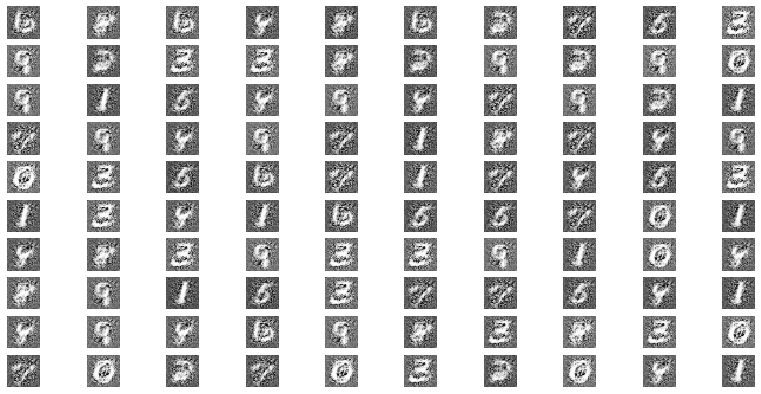

In [73]:
latent_z = Variable(t.randn(batch_size, z_dim).to(device))
y_ = (t.rand(batch_size, 1) * 10).type(t.LongTensor).to(device)
y_label = t.zeros(batch_size, 10).to(device)
y_label = y_label.scatter_(1, y_.view(batch_size, 1), 1)

G_samples = G(latent_z,y_label)
G_samples = G_samples.view(batch_size,28,28).detach().cpu().numpy()

figure = plt.figure(figsize=(14,7))

for i in range(batch_size):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(G_samples[i],cmap="gray")
plt.show()

In [74]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [75]:
def test_cgan(c,no_images):
    condition = [c]*no_images 
    onehot = np.eye(10)[condition]

    onehot = t.from_numpy(onehot)
    onehot = onehot.to(device)
    onehot = onehot.float()
    latent_z = Variable(t.randn(no_images, z_dim).to(device))
    
    G_samples = G(latent_z,onehot)
    G_samples = G_samples.view(no_images,28,28)

    G_samples =G_samples.detach().cpu().numpy()
    
    figure = plt.figure(figsize=(4,3))
    for i in range(no_images):
        plt.subplot(int(math.sqrt(no_images)),int(math.sqrt(no_images)),i+1)
        plt.axis("off")
        plt.imshow(G_samples[i])
#     plt.show()
#     plt.close()

    return G_samples


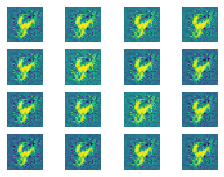

In [76]:
G_samples = test_cgan(4,16)

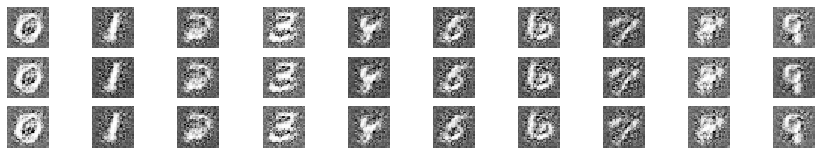

In [77]:
def plot_all_gans():
    
    figure = plt.figure(figsize=(15,9))
    k =0
    for i in range(3):
        for j in range(10):
            k+=1
            condition = [j] 
            onehot = np.eye(10)[condition]

            onehot = t.from_numpy(onehot)
            onehot = onehot.to(device)
            onehot = onehot.float()
            latent_z = Variable(t.randn(1, z_dim).to(device))

            G_samples = G(latent_z,onehot)
            G_samples = G_samples.view(28,28)
            G_samples = G_samples.detach().cpu().numpy()

            plt.subplot(10,10,k)
            plt.axis("off")
            plt.imshow(G_samples,cmap="gray")

plot_all_gans()

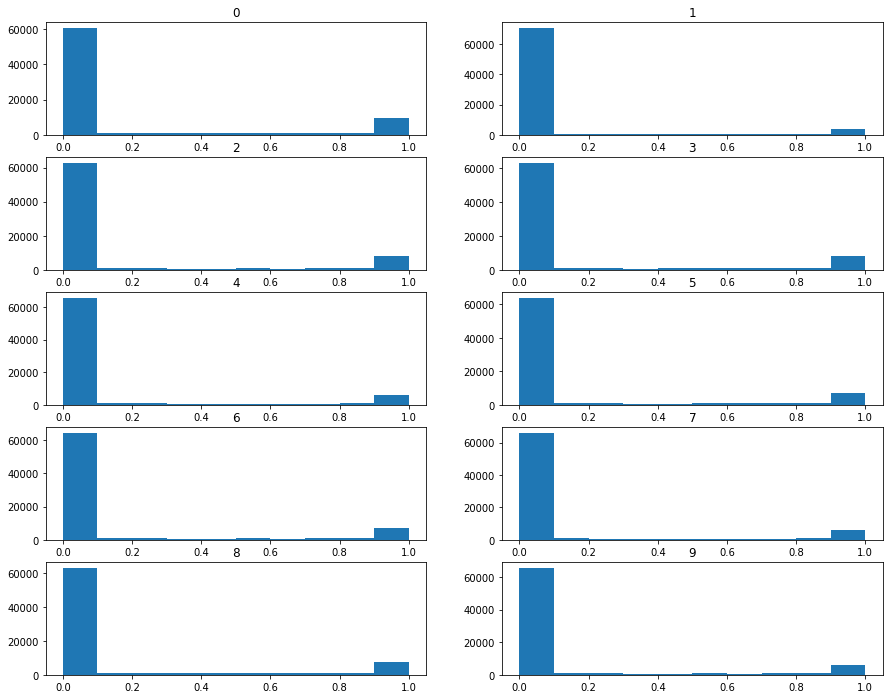

In [78]:
def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index]

def plot_real_images():
    figure = plt.figure(figsize=(15,12))

    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(5,2,i+1)
        _= plt.hist(class_arrayX[:100].reshape(-1))
        plt.title(i)

    plt.savefig("real.png")
    
plot_real_images()

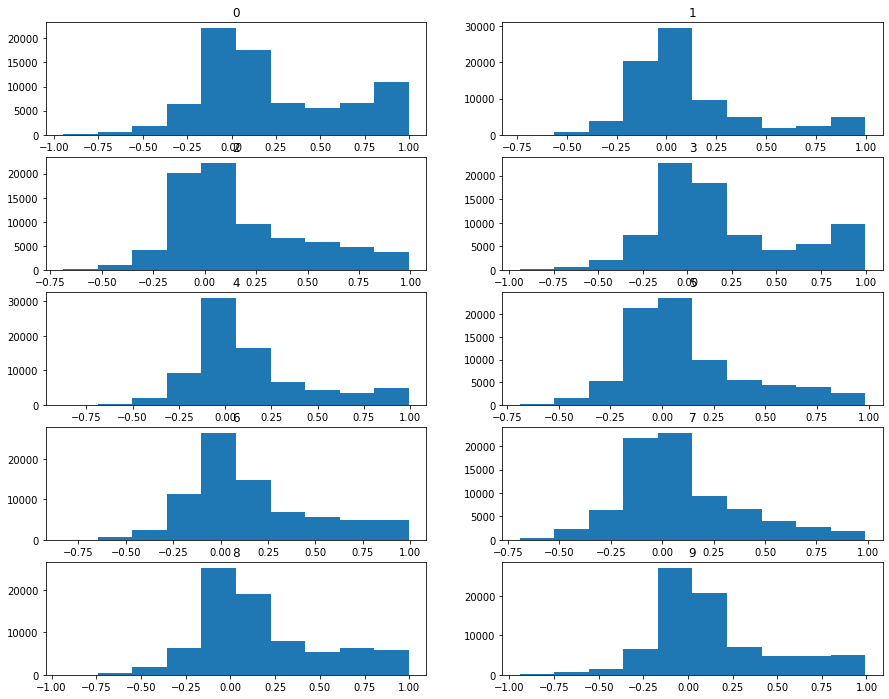

In [79]:
figure = plt.figure(figsize=(15,12))

for i in range(10):
    plt.subplot(5,2,i+1)
    G_samples = test_cgan(int(i),100)
    plt.close()
    _= plt.hist(G_samples.reshape(-1))
    plt.title(i)
    
plt.savefig("Generator distribution")